In [1]:
import librosa
import numpy as np
import math
import pandas as pd
import re
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path
import json

In [3]:
def play_audio(signal, rate):
    return Audio(data=signal, rate=rate)

In [11]:
def get_onset_values(audio, sr, row):
    start = row['start_idx']
    end = row['end_idx']   
    # More standard but slower because it has to load in file
    # Each time. Either speed or assume quality risk.
#     clip, sr = librosa.load(wavs[0],
#                             sr=librosa.core.get_samplerate(wavs[0]),
#                             offset=row['start'],
#                             duration=row['length']
#                            )
    # Faster but MIGHT (don't know how likely) cause data quality issues
    clip = audio[start:end]


    try:
        o_env = librosa.onset.onset_strength(clip, sr=sr, max_size=5)
        times = librosa.times_like(o_env, sr=sr)
        onset_times = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, units="time")
        onset_dt = librosa.feature.delta(o_env)

        row['onset_count'] = onset_times.shape[0]
        row['onset_rate'] = row['onset_count']/row['length']
        
        onset_times_diff = np.diff(onset_times)
        row['onset_time_diff_mean'] = np.mean(onset_times_diff)
        row['onset_time_diff_var'] = np.var(onset_times_diff)
        
        row['onset_strength_mean'] = np.mean(o_env)
        row['onset_strength_seg_var'] = np.var(o_env)
        row['onset_strength_seg_std'] = np.std(o_env)
        row['onset_delta_abs_mean'] = np.mean(np.abs(onset_dt))
        row['onset_delta_var'] = np.var(onset_dt)

    except Exception as e:
        print(f"{row['file']} {row['start']}:{row['end']}, {e}")
        row['onset_count'] = 0
        row['onset_rate'] = 0
        row['onset_time_diff_mean'] = 0
        row['onset_time_diff_var'] = 0
        row['onset_strength_mean'] = 0
        row['onset_strength_seg_var'] = 0
        row['onset_strength_seg_std'] = 0
        row['onset_delta_abs_mean'] = 0
        row['onset_delta_var'] = 0

        
    return row

In [4]:
## One Recording Example

wavs = [path for path in Path('wavs/').rglob('*.wav')]
jsons = [path for path in Path('wavs/').rglob('*.json')]

wav_file, wav_sr = librosa.load(wavs[0], sr=librosa.core.get_samplerate(wavs[0]))

df = pd.read_json(jsons[0])
df['file'] = wavs[0].name
df['length'] = df['end'] - df['start']
df['start_idx'] = np.floor(df['start']*wav_sr).astype(int)
df['end_idx'] = np.ceil(df['end']*wav_sr).astype(int)
df['word_count'] = df['text'].apply(lambda x: len(x.split(" ")))

data = df.loc[(df['word_count'] >= 40) & (df['speaker_role'] == 'scotus_justice')].copy().reset_index(drop=True)

print(f'{wav_file.shape[0]:,} samples with sampling rate {wav_sr}')
print(f'{df.shape[0]} transcript lines')
print(f"{data.shape[0]} viable segments")

In [9]:
# play_audio(wav_file, wav_sr)

In [10]:
data.sample(n=4)

,start,end,speaker,speaker_role,text,file,length,start_idx,end_idx,word_count
14,1391.56,1419.96,Neil_Gorsuch,scotus_justice,Okay. Judge Kelly found that the decree would ...,142-orig.wav,28.40,22264960,22719360,66
34,3477.64,3521.00,Brett_M_Kavanaugh,scotus_justice,"Thank you, Mr. Chief Justice. And good morning...",142-orig.wav,43.36,55642240,56336000,138
24,2351.56,2369.68,Clarence_Thomas,scotus_justice,"So the -- when reading the -- Florida's brief,...",142-orig.wav,18.12,37624960,37914880,49
2,297.56,341.56,Clarence_Thomas,scotus_justice,"Thank you, Mr. Chief Justice. Mr. Garre, a cou...",142-orig.wav,44.00,4760960,5464960,128


In [12]:
data = data.apply(lambda x: get_onset_values(wav_file, wav_sr, x), axis=1)

C:\Users\yagne\anaconda3\envs\librosa\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [13]:
data.sample(n=2)

,start,end,speaker,speaker_role,text,file,length,start_idx,end_idx,word_count,onset_count,onset_rate,onset_time_diff_mean,onset_time_diff_var,onset_strength_mean,onset_strength_seg_var,onset_strength_seg_std,onset_delta_abs_mean,onset_delta_var
8,889.0,909.64,Samuel_A_Alito_Jr,scotus_justice,"No, I -- I understand all that. You -- you hav...",142-orig.wav,20.64,14224000,14554240,66,59,2.858527,0.349241,0.091958,0.778780,2.017639,1.420436,0.143877,0.055649
12,1184.4,1210.48,Elena_Kagan,scotus_justice,"Mr. Garre, you said a while ago that Florida w...",142-orig.wav,26.08,18950400,19367680,70,64,2.453988,0.389079,0.169861,0.885344,3.094536,1.759129,0.154615,0.088599


In [14]:
%%time
all_data = []

for w in wavs:
    wav_file, wav_sr = librosa.load(w, sr=librosa.core.get_samplerate(w), )
    df = pd.read_json(os.path.join(w.parent,w.name.replace(".wav",".json")))
    df['file'] = w.name
    df['line'] = df.index
    df['length'] = df['end'] - df['start']
    df['start_idx'] = np.floor(df['start']*wav_sr).astype(int)
    df['end_idx'] = np.ceil(df['end']*wav_sr).astype(int)
    df['word_count'] = df['text'].apply(lambda x: len(x.split(" ")))
    
    data = df.loc[(df['word_count'] >= 40) & (df['speaker_role'] == 'scotus_justice')].copy().reset_index(drop=True)
    data = data.apply(lambda x: get_onset_values(wav_file, wav_sr, x), axis=1)
    
    all_data.append(data)
    
all_data_df = pd.concat(all_data)
print("\n Record Info:")
print(all_data_df.shape)
all_data_df.to_parquet("data.pq", engine="fastparquet")

C:\Users\yagne\anaconda3\envs\librosa\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
C:\Users\yagne\anaconda3\envs\librosa\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=0
  warnings.warn(


19-123.wav 1886.0:1885.0, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2239.4:2304.8, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2328.24:2375.52, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2442.04:2455.44, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2477.6:2506.76, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2534.56:2556.04, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2587.28:2712.64, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2758.6:2818.6, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2871.24:2933.08, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 2970.04:2995.28, can't extend empty axis 0 using modes other than 'constant' or 'empty'
20-18.wav 3062.84:3086.68,

In [15]:
check = pd.read_parquet("data.pq", engine="fastparquet")
check.sample(n=2)

,start,end,speaker,speaker_role,text,file,line,length,start_idx,end_idx,word_count,onset_count,onset_rate,onset_time_diff_mean,onset_time_diff_var,onset_strength_mean,onset_strength_seg_var,onset_strength_seg_std,onset_delta_abs_mean,onset_delta_var
index,,,,,,,,,,,,,,,,,,,,
16,1361.15,1377.50,Elena_Kagan,scotus_justice,Okay. And can I get one short -- more short on...,20-107.wav,87,16.35,21778400,22040000,42,52,3.180428,0.295529,0.068009,0.889596,3.292702,1.81458,0.155931,0.082723
6,586.20,637.64,Samuel_A_Alito_Jr,scotus_justice,"Well, that would get into some very difficult ...",19-351.wav,39,51.44,9379200,10202240,100,113,2.196734,0.457143,0.165731,0.743671,2.328372,1.52590,0.147177,0.065328


In [16]:
print("Bad Records:",check.loc[check['onset_count'] == 0].shape[0])

Bad Records: 52


In [ ]:
check.describe()

In [21]:
check['word_rate'] = check['word_count']/check['length']

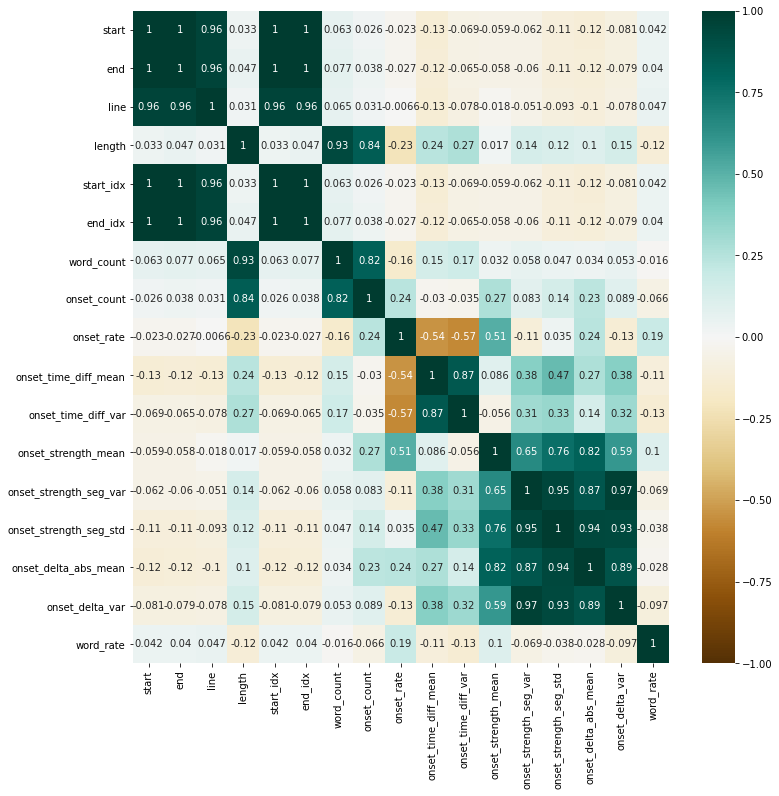

In [22]:
plt.figure(figsize=(12,12))
sns.heatmap(check.corr(), annot=True, vmin=-1, vmax=1, cmap='BrBG')
plt.show()

In [18]:
# Histogram --> entropy of onset time difference






# Could change to median absolute deviation to make no assumptions on distribution (n = 3 for some judges)
#     recording_stats = data.groupby('speaker').agg({"onset_rate": ["mean","std"], "onset_strength_mean": ["mean","std"]})
#     exploded_recording_stats = []
#     for r in recording_stats.iterrows():
#         info = {
#             "speaker": r[0],
#             "rec_onset_rate_mean": r[1]['onset_rate']['mean'],
#             "rec_onset_rate_std": r[1]['onset_rate']['std'],
#             "rec_onset_str_mean": r[1]['onset_strength_mean']['mean'],
#             "rec_onset_str_std": r[1]['onset_strength_mean']['std'],
#         }
#         exploded_recording_stats.append(info)
#     recording_stats = pd.DataFrame(exploded_recording_stats)

#     data = data.merge(recording_stats, on="speaker")
#     data['rec_onset_rate_dev'] = (data['onset_rate'] - data['rec_onset_rate_mean'])/data['rec_onset_rate_std']
#     data['rec_onset_str_dev'] = (data['onset_strength_mean'] - data['rec_onset_str_mean'])/data['rec_onset_str_std']

# data['rec_onset_rate_dev'] = (data['onset_rate'] - data['rec_onset_rate_mean'])/data['rec_onset_rate_std']
# data['rec_onset_str_dev'] = (data['onset_strength_mean'] - data['rec_onset_str_mean'])/data['rec_onset_str_std']

In [19]:
# Number of onsets
# Onset Rate
# Time difference between onsets (np.diff) --> mean, variance

# For across-audio file segments --> stick within one year of case dates
# Project down to 32 mels instead of default 144 mels